**Ustawienie środowiska**

Na początku wczytaliśmy potrzebne biblioteki i sprawdziliśmy ich wersje.


In [ ]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

scipy: 1.4.1
numpy: 1.21.5
matplotlib: 3.2.2
pandas: 1.3.5
statsmodels: 0.10.2
sklearn: 1.0.2


W kolejnym korku wczytaliśmy dane, a następnie stworzyliśmy zmienną Y, oznaczającą zwrot z inwestycji danego dnia (cena zamknięcia/cena otwarcia wyrażone w proc.). Stopa zwrotu została obliczona w ten sposób ze względu na braki danych w przypadku wielu spółek. Jest to jednak ciekawe wyzwanie, które zmowytywowało nas do oceny modelu pod kątem inwestycji krótkoterminowych.

                Y           C
count  169.000000  169.000000
mean    -0.094178   11.312454
std      1.951327   15.540471
min    -17.948717  -23.740358
25%     -0.733154    0.740587
50%     -0.142784   13.134368
75%      0.950371   21.604002
max      4.529249   38.396677


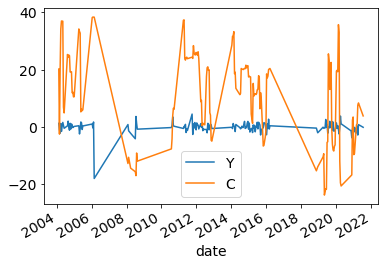

                   Y          C
date                           
2004-02-11  1.297605  20.238564
2004-02-25 -0.943393  -2.456846
2004-03-10 -2.148997  20.083009
2004-03-24  1.246378  34.202361
2004-04-07 -1.518319  37.016435
...              ...        ...
2021-03-10 -0.561901   0.740587
2021-03-24  0.340863   1.186310
2021-04-07 -2.788512   7.665826
2021-04-21  0.863601   8.420230
2021-07-28 -0.079918   3.894704

[169 rows x 2 columns]


In [ ]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('convictions_returns.csv', parse_dates=['date'], index_col='date')

series['Y'] = series.Close/series.Open*100-100
series['C'] = series.conviction/series.conviction[-1]*100-100

X = series[(series.symbol == "SHW")]
X = X[['Y','C']]

print(X.describe())

X.plot()
pyplot.show()

print(X)

Sprawdziliśmy relację między "daily returns", a "convictions" - jest ona ujemna, ale pomijalna. Przejdziemy jednak dalej w celu zobrazowania problemu zadania.

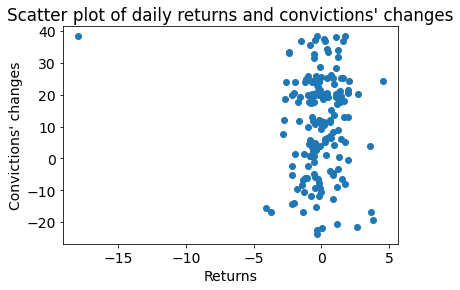

,Y,C
Y,1.000000,-0.037547
C,-0.037547,1.000000


In [ ]:
import matplotlib.pyplot as plt

plt.xlabel("Returns")
plt.ylabel("Convictions' changes")
plt.title("Scatter plot of daily returns and convictions' changes")
plt.scatter(X['Y'], X['C'])
plt.show()
X.corr()

O niskim dopasowanu modelu świadczą również jego statystyki opisowe.

In [ ]:
import statsmodels.formula.api as smf
### Create an instance of the class OLS
slr_sm_model = smf.ols('C ~ Y', data=X)

### Fit the model (statsmodels calculates beta_0 and beta_1 here)
slr_sm_model_ko = slr_sm_model.fit()

### Summarize the model

print(slr_sm_model_ko.summary()) 

param_slr = slr_sm_model_ko.params

                            OLS Regression Results                            
Dep. Variable:                      C   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2358
Date:                Sun, 27 Mar 2022   Prob (F-statistic):              0.628
Time:                        11:47:06   Log-Likelihood:                -702.82
No. Observations:                 169   AIC:                             1410.
Df Residuals:                     167   BIC:                             1416.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.2843      1.200      9.407      0.0

Prosta regresja liniowa wygląda jednak w następujący spośob.

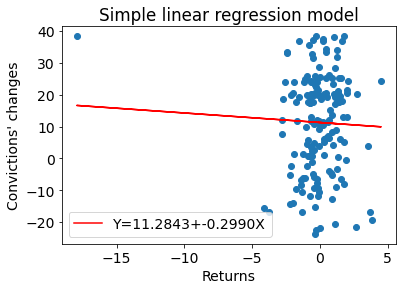

In [ ]:
plt.xlabel("Returns")
plt.ylabel("Convictions' changes")
plt.title("Simple linear regression model")
plt.scatter(X['Y'],X['C'])
plt.plot(X['Y'], param_slr.Intercept+param_slr.Y * X['Y'],
         label='Y={:.4f}+{:.4f}X'.format(param_slr.Intercept, param_slr.Y), 
         color='red')
plt.legend()
plt.show()

**Drugie podejście**

Model z wykorzystaniem biblioteki *sklearn*.

In [ ]:
#X = X.values
#X.conviction = X.conviction.astype('float32')
#X = series
#split_point = int(0.9*len(X))
#dataset, validation = X[0:split_point], X[split_point:]

#print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
#print(dataset)

Zbiór podzieliliśmy na trenujący i testowy w celu sprawdzenia dopasowania i potencjału predykcyjnego modelu.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
x,y=X.conviction, X.Y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=1)
print(y_train)

date
2008-07-30    1.200151
2019-07-03    0.903532
2020-12-02   -3.744502
2021-04-21    0.863601
2015-07-29    1.666481
                ...   
2019-06-05    2.654411
2019-07-31   -0.001945
2012-09-26   -0.961209
2019-09-11    1.224519
2008-08-13   -0.733154
Name: Y, Length: 101, dtype: float64


Do realizacji modelu stworzyliśmy obiekt regresji liniowej i trenowaliśmy go na przygotowanych zbiorach trenujących. Na wyjściu przedstawiliśmy współczynniki regresji i wynik wariancji.

In [ ]:
 # create linear regression object
reg = linear_model.LinearRegression()
 
# train the model using the training sets
reg.fit(X_train, y_train)
 
# regression coefficients
print('Coefficients: ', reg.coef_)
 
# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test)))
 


Coefficients:  [ 1.0000000e+00 -3.3271266e-16]
Variance score: 1.0


Następnie przedstawiliśmy na wykresie błędy resztkowe zarówno dla zbioru trenującego, jak i testowego. 

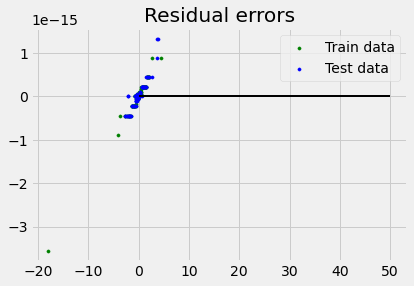

In [ ]:
plt.style.use('fivethirtyeight')
 
## residual errors in training data
plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train,
            color = "green", s = 10, label = 'Train data')
 
## residual errors in test data
plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test,
            color = "blue", s = 10, label = 'Test data')

plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
plt.legend(loc = 'upper right')
plt.title("Residual errors")
plt.show()